In [101]:
import pandas as pd
pd.set_option('display.max_columns', 50)
import seaborn as sns
from surprise import Dataset
from surprise import Reader
from surprise import SVD
from surprise.prediction_algorithms import knns
from surprise.model_selection import train_test_split, KFold, GridSearchCV
from surprise.similarities import cosine, msd, pearson
from surprise import accuracy

## Intro to problem

### Load Data

In [102]:
# load and check first entries of dataframe with information on books
books = pd.read_csv('books.csv')
books.head()

,book_id,goodreads_book_id,best_book_id,work_id,books_count,isbn,isbn13,authors,original_publication_year,original_title,title,language_code,average_rating,ratings_count,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,image_url,small_image_url
0,1,2767052,2767052,2792775,272,439023483,9.780439e+12,Suzanne Collins,2008.0,The Hunger Games,"The Hunger Games (The Hunger Games, #1)",eng,4.34,4780653,4942365,155254,66715,127936,560092,1481305,2706317,https://images.gr-assets.com/books/1447303603m...,https://images.gr-assets.com/books/1447303603s...
1,2,3,3,4640799,491,439554934,9.780440e+12,"J.K. Rowling, Mary GrandPré",1997.0,Harry Potter and the Philosopher's Stone,Harry Potter and the Sorcerer's Stone (Harry P...,eng,4.44,4602479,4800065,75867,75504,101676,455024,1156318,3011543,https://images.gr-assets.com/books/1474154022m...,https://images.gr-assets.com/books/1474154022s...
2,3,41865,41865,3212258,226,316015849,9.780316e+12,Stephenie Meyer,2005.0,Twilight,"Twilight (Twilight, #1)",en-US,3.57,3866839,3916824,95009,456191,436802,793319,875073,1355439,https://images.gr-assets.com/books/1361039443m...,https://images.gr-assets.com/books/1361039443s...
3,4,2657,2657,3275794,487,61120081,9.780061e+12,Harper Lee,1960.0,To Kill a Mockingbird,To Kill a Mockingbird,eng,4.25,3198671,3340896,72586,60427,117415,446835,1001952,1714267,https://images.gr-assets.com/books/1361975680m...,https://images.gr-assets.com/books/1361975680s...
4,5,4671,4671,245494,1356,743273567,9.780743e+12,F. Scott Fitzgerald,1925.0,The Great Gatsby,The Great Gatsby,eng,3.89,2683664,2773745,51992,86236,197621,606158,936012,947718,https://images.gr-assets.com/books/1490528560m...,https://images.gr-assets.com/books/1490528560s...


In [3]:
books.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 23 columns):
book_id                      10000 non-null int64
goodreads_book_id            10000 non-null int64
best_book_id                 10000 non-null int64
work_id                      10000 non-null int64
books_count                  10000 non-null int64
isbn                         9300 non-null object
isbn13                       9415 non-null float64
authors                      10000 non-null object
original_publication_year    9979 non-null float64
original_title               9415 non-null object
title                        10000 non-null object
language_code                8916 non-null object
average_rating               10000 non-null float64
ratings_count                10000 non-null int64
work_ratings_count           10000 non-null int64
work_text_reviews_count      10000 non-null int64
ratings_1                    10000 non-null int64
ratings_2                    10000 n

In [41]:
books.describe()

,book_id,goodreads_book_id,best_book_id,work_id,books_count,isbn13,original_publication_year,average_rating,ratings_count,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5
count,10000.00000,1.000000e+04,1.000000e+04,1.000000e+04,10000.000000,9.415000e+03,9979.000000,10000.000000,1.000000e+04,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,1.000000e+04
mean,5000.50000,5.264697e+06,5.471214e+06,8.646183e+06,75.712700,9.755044e+12,1981.987674,4.002191,5.400124e+04,5.968732e+04,2919.955300,1345.040600,3110.885000,11475.893800,1.996570e+04,2.378981e+04
std,2886.89568,7.575462e+06,7.827330e+06,1.175106e+07,170.470728,4.428619e+11,152.576665,0.254427,1.573700e+05,1.678038e+05,6124.378132,6635.626263,9717.123578,28546.449183,5.144736e+04,7.976889e+04
min,1.00000,1.000000e+00,1.000000e+00,8.700000e+01,1.000000,1.951703e+08,-1750.000000,2.470000,2.716000e+03,5.510000e+03,3.000000,11.000000,30.000000,323.000000,7.500000e+02,7.540000e+02
25%,2500.75000,4.627575e+04,4.791175e+04,1.008841e+06,23.000000,9.780316e+12,1990.000000,3.850000,1.356875e+04,1.543875e+04,694.000000,196.000000,656.000000,3112.000000,5.405750e+03,5.334000e+03
50%,5000.50000,3.949655e+05,4.251235e+05,2.719524e+06,40.000000,9.780452e+12,2004.000000,4.020000,2.115550e+04,2.383250e+04,1402.000000,391.000000,1163.000000,4894.000000,8.269500e+03,8.836000e+03
75%,7500.25000,9.382225e+06,9.636112e+06,1.451775e+07,67.000000,9.780831e+12,2011.000000,4.180000,4.105350e+04,4.591500e+04,2744.250000,885.000000,2353.250000,9287.000000,1.602350e+04,1.730450e+04
max,10000.00000,3.328864e+07,3.553423e+07,5.639960e+07,3455.000000,9.790008e+12,2017.000000,4.820000,4.780653e+06,4.942365e+06,155254.000000,456191.000000,436802.000000,793319.000000,1.481305e+06,3.011543e+06


In [44]:
books.isna().sum()

book_id                         0
goodreads_book_id               0
best_book_id                    0
work_id                         0
books_count                     0
isbn                          700
isbn13                        585
authors                         0
original_publication_year      21
original_title                585
title                           0
language_code                1084
average_rating                  0
ratings_count                   0
work_ratings_count              0
work_text_reviews_count         0
ratings_1                       0
ratings_2                       0
ratings_3                       0
ratings_4                       0
ratings_5                       0
image_url                       0
small_image_url                 0
dtype: int64

In [37]:
# load and check first entries of ratings dataset
ratings = pd.read_csv('ratings.csv')
ratings.head()

,user_id,book_id,rating
0,1,258,5
1,2,4081,4
2,2,260,5
3,2,9296,5
4,2,2318,3


In [5]:
# check dataset information
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5976479 entries, 0 to 5976478
Data columns (total 3 columns):
user_id    int64
book_id    int64
rating     int64
dtypes: int64(3)
memory usage: 136.8 MB


In [21]:
# check if we have any null values
ratings.isna().sum()

user_id    0
book_id    0
rating     0
dtype: int64

## EDA

**write a bit about it**

In [6]:
print(f'Number of unique users: {ratings.user_id.nunique()}')
print(f'Number of unique items(books): {ratings.book_id.nunique()}')

Number of unique users: 53424
Number of unique items(books): 10000


We have almost 6 million ratings by over 53 thousand unique users for 10,000 books.

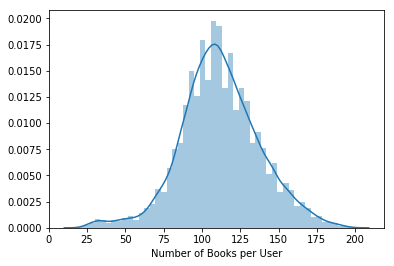

In [7]:
sns.distplot(ratings.user_id.value_counts(), axlabel='Number of Books Rated per User');

In [8]:
print(f'The mean number of books rated by user is {ratings.user_id.value_counts().mean()}')
print(f'The median number of books rated by user is {ratings.user_id.value_counts().median()}')

The mean number of books rated by user is 111.86880428271938
The median number of books rated by user is 111.0


In [93]:
count = ratings.rating.value_counts()
count.index

Int64Index([4, 5, 3, 2, 1], dtype='int64')

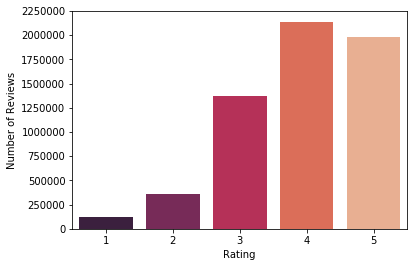

In [10]:
ax = sns.barplot(x=count.index, y=count, palette='rocket')
ax.set_ylabel('Number of Reviews')  
ax.set_xlabel('Rating'); 

In [94]:
# check users who give more 5 stars ratings and number of such ratings given by each user
users_most5_ratings = ratings.loc[(ratings.rating == 5)].groupby('user_id').size().sort_values(ascending=False)
users_most5_ratings.head(10)

user_id
53293    194
49288    193
49297    192
49289    192
49295    192
53292    192
50104    189
50133    189
30184    188
50101    187
dtype: int64

In [95]:
# check users who give more 1 star ratings and number of such ratings given by each user
users_most1_ratings = ratings.loc[(ratings.rating == 1)].groupby('user_id').size().sort_values(ascending=False)
users_most1_ratings.head(10)

user_id
44171    167
49586    145
35678    134
51577    130
49660    127
43545    121
52698    117
51328    113
52700    112
38883    110
dtype: int64

In [117]:
# check what are the top 10 best rated books
best_rated = books['average_rating'].sort_values(ascending=False)
books[['title', 'authors']].iloc[best_rated.head(10).index]

,title,authors
3627,The Complete Calvin and Hobbes,Bill Watterson
3274,"Harry Potter Boxed Set, Books 1-5 (Harry Potte...","J.K. Rowling, Mary GrandPré"
861,"Words of Radiance (The Stormlight Archive, #2)",Brandon Sanderson
7946,ESV Study Bible,"Anonymous, Lane T. Dennis, Wayne A. Grudem"
8853,Mark of the Lion Trilogy,Francine Rivers
4482,It's a Magical World: A Calvin and Hobbes Coll...,Bill Watterson
421,"Harry Potter Boxset (Harry Potter, #1-7)",J.K. Rowling
6360,There's Treasure Everywhere: A Calvin and Hobb...,Bill Watterson
3752,"Harry Potter Collection (Harry Potter, #1-6)",J.K. Rowling
6919,The Indispensable Calvin and Hobbes,Bill Watterson


There is a lot of love for Calvin and Hobbes and for Harry Potter! Let's check what books are the most disliked ones.

In [118]:
# check what are the top 10 worst rated books
worst_rated = books['average_rating'].sort_values()
books[['title', 'authors']].iloc[worst_rated.head(10).index]

,title,authors
1792,One Night at the Call Center,Chetan Bhagat
3549,The Almost Moon,Alice Sebold
8006,The Finkler Question,Howard Jacobson
9020,Lost,"Gregory Maguire, Douglas Smith"
4008,Four Blondes,Candace Bushnell
8165,Among the Ten Thousand Things,Julia Pierpont
8873,Tell-All,Chuck Palahniuk
4282,Revenge Wears Prada: The Devil Returns (The De...,Lauren Weisberger
4613,The Emperor's Children,Claire Messud
8959,The Red House,Mark Haddon


Well, I'm glad I didn't read any of these! 

In [137]:
# check what are the top 10 books with the most 5 stars ratings
most_5stars = books['ratings_5'].sort_values(ascending=False)
most_5stars = books[['original_title','authors']].iloc[most_5stars.head(10).index]
most_5stars

,original_title,authors
1,Harry Potter and the Philosopher's Stone,"J.K. Rowling, Mary GrandPré"
0,The Hunger Games,Suzanne Collins
3,To Kill a Mockingbird,Harper Lee
2,Twilight,Stephenie Meyer
24,Harry Potter and the Deathly Hallows,"J.K. Rowling, Mary GrandPré"
5,The Fault in Our Stars,John Green
17,Harry Potter and the Prisoner of Azkaban,"J.K. Rowling, Mary GrandPré, Rufus Beck"
23,Harry Potter and the Goblet of Fire,"J.K. Rowling, Mary GrandPré"
26,Harry Potter and the Half-Blood Prince,"J.K. Rowling, Mary GrandPré"
9,Pride and Prejudice,Jane Austen


In [136]:
# check what are the top 10 books with the most 1 star ratings
most_1star = books['ratings_1'].sort_values(ascending=False)
most_1star = books[['original_title','authors']].iloc[most_1star.head(10).index]
most_1star

,original_title,authors
2,Twilight,Stephenie Meyer
33,Fifty Shades of Grey,E.L. James
7,The Catcher in the Rye,J.D. Salinger
48,"New Moon (Twilight, #2)",Stephenie Meyer
55,Breaking Dawn,Stephenie Meyer
39,"Eat, pray, love: one woman's search for everyt...",Elizabeth Gilbert
27,Lord of the Flies,William Golding
4,The Great Gatsby,F. Scott Fitzgerald
51,Eclipse,Stephenie Meyer
8,Angels & Demons,Dan Brown


In [138]:
# one book is in both top 10 most liked and most disliked - call it a polarizer!
most_5stars.merge(most_1star)

,original_title,authors
0,Twilight,Stephenie Meyer


## Modeling

### Memory-based Collaboration Filtering with surprise library

Let's start with a simple tecnique. We will apply a memory-based collaboration filtering model using surprise library. We need to load the dataset into the right format in order to use it with surprise library.

In [11]:
# define reader
reader = Reader(rating_scale=(1, 5))

# load dataframe into correct format for surprise library
data = Dataset.load_from_df(ratings[['user_id', 'book_id', 'rating']], reader)

In [12]:
# check it's the right data type
type(data)

surprise.dataset.DatasetAutoFolds

Here we will split the data to have a training and testing set, and to avoid data leakage.

In [13]:
# Split into train and test set
trainset, testset = train_test_split(data, test_size=0.2)

In [14]:
# check size of test set and have a look at how one sample looks like
print(len(testset))
print(testset[0])

1195296
(22352, 1100, 4.0)


In [15]:
# confirm number of items and users in data
print('Number of users: ', trainset.n_users, '\n')
print('Number of items: ', trainset.n_items, '\n')

Number of users:  53424 

Number of items:  10000 



Because we have more users than books we will start simple and calculate item-item similarity. We know that different ways to measure similarity will yield different results. I will try using different similarity metrics  - cosine similarity and pearson correlation - with a basic KNN model and see which performs better.

In [16]:
# define a cosine metric
sim_cos = {'name':'cosine', 'user_based':False}

In [17]:
# define and fit a basic KNN model with a cosine metric
basic = knns.KNNBasic(sim_options=sim_cos)
basic.fit(trainset)

Computing the cosine similarity matrix...
Done computing similarity matrix.


In [18]:
# make predictions
predictions = basic.test(testset)

In [19]:
# check accuracy
print(accuracy.rmse(predictions))

RMSE: 0.8828
0.8827816563176663


The root mean squared error is of .88, which is high when you consider that we are talking about a rating in a range of 1 to 5. Let's see if we get a better model performance by using a pearson correlation metric instead.

In [20]:
# define fit and evaluate a KNN basic model with pearson correlation metric
sim_pearson = {'name':'pearson', 'user_based':False}
basic_pearson = knns.KNNBasic(sim_options=sim_pearson)
basic_pearson.fit(trainset)
predictions = basic_pearson.test(testset)
print(accuracy.rmse(predictions))

Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.8727
0.8726899246170825


The pearson correlation seems to be performing slightly better. Let's now try using this metric with other KNN models that are a little more advanced.

In [ ]:
# KNN baseline model
sim_pearson_baseline = {'name': 'pearson_baseline','shrinkage': 0, 'user_based':False}
knn_baseline = knns.KNNBaseline(sim_options=sim_pearson)
knn_baseline.fit(trainset)
predictions = knn_baseline.test(testset)
print(accuracy.rmse(predictions))

In [ ]:
# KNN with means model
sim_pearson = {'name':'pearson', 'user_based':False}
knn_baseline = knns.KNNWithMeans(sim_options=sim_pearson)
knn_baseline.fit(trainset)
predictions = knn_baseline.test(testset)
print(accuracy.rmse(predictions))

In [ ]:
# define a cross-validation iterator
kf = KFold(n_splits=3)

algo = SVD()

for trainset, testset in kf.split(data):

    # train and test algorithm.
    algo.fit(trainset)
    predictions = algo.test(testset)

    # Compute and print Root Mean Squared Error
    accuracy.rmse(predictions, verbose=True)

In [ ]:
param_grid = {'n_factors':[20, 100],'n_epochs': [5, 10], 'lr_all': [0.002, 0.005],
              'reg_all': [0.4, 0.6]}
gs_model = GridSearchCV(SVD, param_grid=param_grid, n_jobs = -1,joblib_verbose=5)
gs_model.fit(data)

In [ ]:
# best RMSE score
print(gs_model.best_score['rmse'])

# combination of parameters that gave the best RMSE score
print(gs_model.best_params['rmse'])